<a href="https://colab.research.google.com/github/MINJILEE-PURDUE/ChatGPT-Political-Compass/blob/main/ChatGPT_Political_Compass_SHAP_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap
!pip install lime

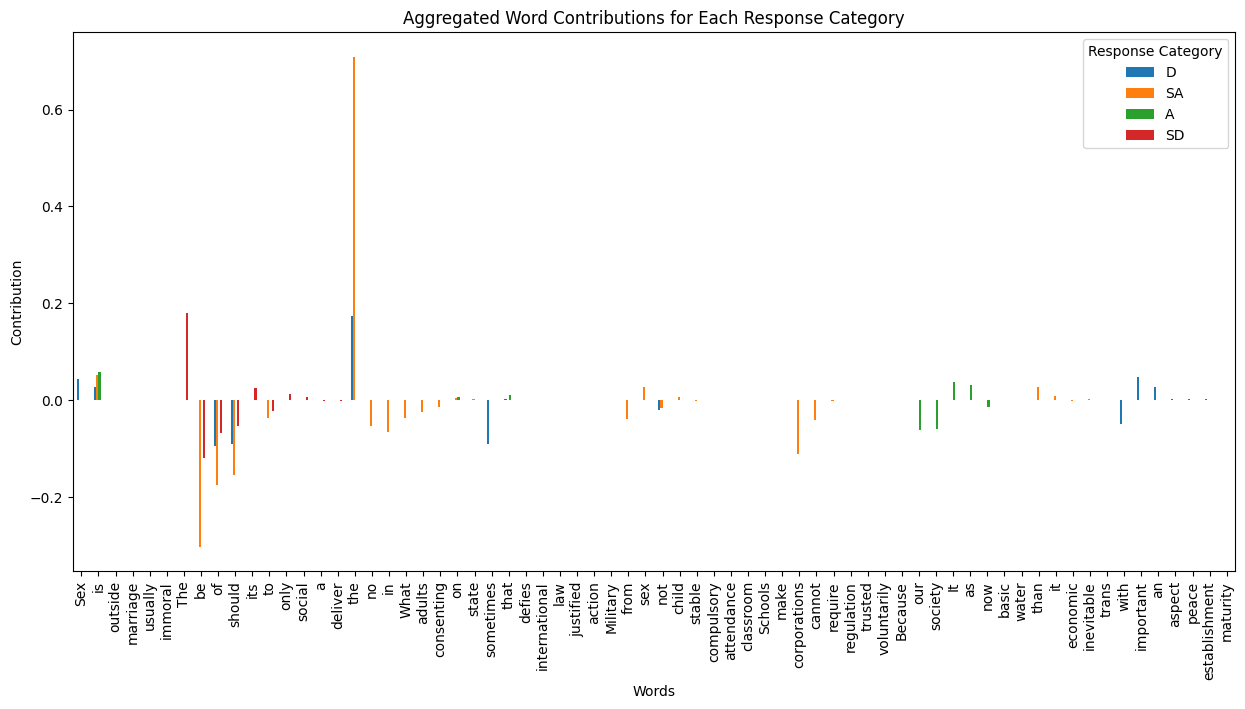

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import lime
import lime.lime_text
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the dataset with the correct encoding
file_path = '/content/sample_data/Political_Compass_Dataset(Sheet3).csv'
df_original = pd.read_csv(file_path, encoding='ISO-8859-1')

# Preprocess the dataset: Extract the statement and the response
df = df_original.dropna(subset=['SD', 'D', 'A', 'SA'], how='all')  # Remove rows where all responses are NaN
df['Statement'] = df.iloc[:, 0]  # Assuming the first column contains the statements

# Drop rows where the 'Statement' is NaN
df = df.dropna(subset=['Statement'])

# Target column: Combine responses into a single target variable (simplification)
response_columns = ['SD', 'D', 'A', 'SA']
df['Response'] = df[response_columns].idxmax(axis=1)  # Simplified response

# Split data into training and testing sets
X = df['Statement']
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=42))
pipeline.fit(X_train, y_train)

# Create a Lime explainer
explainer = lime.lime_text.LimeTextExplainer(class_names=response_columns)

# Select a few sample questions to analyze
num_samples = 10
sample_indices = np.random.choice(X_test.index, num_samples, replace=False)

# Generate Lime explanations for each sample
explanations = []
for idx in sample_indices:
    exp = explainer.explain_instance(X_test.loc[idx], pipeline.predict_proba, num_features=10)
    explanations.append((idx, exp))

# Initialize a dictionary to hold word contributions
word_contributions = defaultdict(lambda: defaultdict(float))

# Extract contributions from each explanation
for idx, exp in explanations:
    for feature, weight in exp.as_list():
        word_contributions[feature][y_test.loc[idx]] += weight

# Convert the dictionary to a DataFrame for easier manipulation and visualization
contrib_df = pd.DataFrame(word_contributions).T.fillna(0)

# Plot the contributions
contrib_df.plot(kind='bar', figsize=(15, 7))
plt.title('Aggregated Word Contributions for Each Response Category')
plt.xlabel('Words')
plt.ylabel('Contribution')
plt.legend(title='Response Category')
plt.show()

In [3]:
def calculate_ideology_score(answers):
    score = 0
    for answer in answers:
        if answer == "SA":
            score += 2
        elif answer == "A":
            score += 1
        elif answer == "D":
            score -= 1
        elif answer == "SD":
            score -= 2
        else:
            print(f"Unknown answer: {answer}. Skipping.")

    return score

# Example answers for all 62 statements (assuming they are in order)
answers = [
    "SA", "D", "D", "SA", "SA", "SD", "SA", "D", "SA", "SD",
    "SA", "SA", "D", "D", "D", "D", "SA", "SA", "D", "D",
    "SD", "D", "D", "A", "SD", "SA", "SD", "SA", "D", "SA",
    "D", "D", "SA", "D", "D", "A", "D", "SD", "SD", "SA", "D",
    "D", "SA", "SD", "SD", "SA", "SD", "D", "SD", "SA", "SD",
    "D", "SD", "SA", "SD", "SA", "SA", "SD", "SA", "SA", "SD"
]

total_score = calculate_ideology_score(answers)

if total_score > 0:
    print("The responses lean towards right-wing ideology.")
elif total_score < 0:
    print("The responses lean towards left-wing ideology.")
else:
    print("The responses are neutral or balanced.")

The responses lean towards left-wing ideology.


In [4]:
!pip uninstall accelerate -y
!pip install accelerate>=0.21.0
!pip uninstall transformers -y
!pip install transformers[torch]

Found existing installation: accelerate 0.31.0
Uninstalling accelerate-0.31.0:
  Successfully uninstalled accelerate-0.31.0
Found existing installation: transformers 4.42.3
Uninstalling transformers-4.42.3:
  Successfully uninstalled transformers-4.42.3
  Using cached transformers-4.42.3-py3-none-any.whl (9.3 MB)


In [6]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

# Example dataset (replace with your actual dataset)
statements = [
    "If economic globalisation is inevitable, it should primarily serve humanity rather than the interests of trans-national corporations."
]
labels = [
    "SA"
]

# Map labels to numerical values
label_map = {"SA": 0, "A": 1, "D": 2, "SD": 3}
labels = [label_map[label] for label in labels]

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token for GPT-2
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=len(label_map))  # Adjust num_labels according to the number of labels

# Tokenize inputs
tokenized_inputs = tokenizer(statements, padding=True, truncation=True, return_tensors="pt")

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: tensor[idx] for key, tensor in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare datasets
train_dataset = CustomDataset(tokenized_inputs, labels)
eval_dataset = CustomDataset(tokenized_inputs, labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./output',
    per_device_train_batch_size=4,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=1000,
    evaluation_strategy="epoch"
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=None  # Add metrics if needed
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('./fine-tuned-gpt')

# Example of using the fine-tuned model for prediction
# Replace with actual prediction logic based on your fine-tuned model
# You can use this to predict ideological leanings for new statements or analyze existing responses.


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.036291
2,No log,0.014829
3,No log,0.009505
